In [1]:
import numpy as np
from ibapi.client import EClient
from ibapi.wrapper import EWrapper  
import ibapi
from ibapi.contract import Contract
from ibapi.order import Order
from ibapi.order_condition import Create, OrderCondition

import threading
import multiprocessing
import time

import logging

# logging.basicConfig(level=logging.ERROR)

In [2]:
ibapi.get_version_string()

'10.19.4'

In [3]:
class IBapi(EWrapper, EClient):
    def __init__(self):
        EClient.__init__(self, self)
        
        # orders details
        self.order_status = {}
        
        self.apple_stock_price = None
        self.data_is_live = None
        self.nextorderId = None
        
        # hitorical data
        self.data_price = {}
        self.historical_data_onlyrth = []
        self.historical_data_notonlyrth = []
        
    def nextValidId(self, orderId: int):
#       super().nextValidId(orderId)
        self.nextorderId = orderId
        print('The next valid order id is: ', self.nextorderId)
        
    def orderStatus(self, orderId, status, filled, remaining, avgFullPrice, permId, parentId, lastFillPrice, clientId, whyHeld, mktCapPrice):
        print('orderStatus - orderid:', orderId, 'status:', status, 'filled', filled, 'remaining', remaining, 'lastFillPrice', lastFillPrice)
        self.order_status[orderId] = {"status": status, "filled": filled, "remaining": remaining}
        
    def openOrder(self, orderId, contract, order, orderState):
        print('openOrder id:', orderId, contract.symbol, contract.secType, '@', contract.exchange, ':', order.action, order.orderType, order.totalQuantity, orderState.status)
        print(type(orderState))
        
    def execDetails(self, reqId, contract, execution):
        print('Order Executed: ', reqId, contract.symbol, contract.secType, contract.currency, execution.execId, execution.orderId, execution.shares, execution.lastLiquidity)
        print(type(execution))
        
    def tickPrice(self, reqId, tickType, price, attrib):
        if tickType:
            if reqId not in self.data_price.keys():
                self.data_price[reqId] = []
            self.data_price[reqId].append(price)
            # print('The current price dictionary is: ', self.data_price)
            
    def marketDataType(self, reqId, marketDataType: int):
        self.data_is_live = True
        print("MarketDataType. ReqId:", reqId, "Type: 1=live, 2=frozen, 3=delayed", marketDataType)
            
    def historicalData(self, reqId, bar):
        self.historical_data_onlyrth.append(bar)
        
    def get_open_order_status(self):
        self.order_status = {} # reset the dictionary
        self.reqOpenOrders()

In [5]:
app.get_open_order_status()

ERROR -1 504 Not connected


In [6]:
app.nextorderId

# create contract objects

In [7]:
#Create contract object

def get_stock_contract(ticker: str):
    contract = Contract()
    contract.symbol = ticker
    contract.secType = 'STK'
    contract.exchange = 'SMART'
    contract.currency = 'USD'
    
    return contract

In [8]:
apple_contract = get_stock_contract("AAPL")

# Create order

In [5]:
def create_parent_order(order_id: int, action: str, price: float, quantity: int) -> Order:
    """Implements stock order.
    action: str (SELL OR BUY)
    price: float (price for the limit order)
    quantity: int (number of shares)
    """
    order = Order()
    order.orderId = order_id
    order.action = action
    order.tif = "DAY"
    order.totalQuantity = quantity
    order.orderType = 'LMT'
    order.lmtPrice = price
    order.allOrNone = True
    order.outsideRth = True

    return order


def create_profit_taker_child_order(parent_order_id: int, child_order_id: int, price: float, quantity: int) -> Order:
    """Implements stock order.
    price: float (price for the limit order)
    quantity: int (number of shares)
    """
    order = Order()
    order.orderId = child_order_id
    order.parentId = parent_order_id
    order.action = "SELL"
    order.tif = "DAY"
    order.totalQuantity = quantity
    order.orderType = 'LMT'
    order.lmtPrice = price
    order.allOrNone = False
    order.outsideRth = True

    return order

# Place order

In [10]:
def place_simple_order(app: IBapi, ticker_symbol: str, action: str, price: float, quantity: int) -> None:
    """Place a limit order.
    action: str (SELL OR BUY)
    price: float (price for the limit order)
    quantity: int (number of shares)
    """
    contract = get_stock_contract(ticker_symbol)
    order = create_parent_order(app.nextorderId, action, price, quantity)  # type: ignore
    order.transmit = True
    app.placeOrder(app.nextorderId, contract, order)
    app.reqIds(-1)  # increment the next valid id (appl.nextorderId)


def place_profit_taker_order(app: IBapi, ticker_symbol: str, price: float, quantity: int) -> None:
    """Place a limit order.
    action: str (SELL OR BUY)
    price: float (price for the limit order)
    quantity: int (number of shares)
    """
    contract = get_stock_contract(ticker_symbol)
    parent_order = create_parent_order(app.nextorderId, "BUY", round(price+0.01, 2), quantity)  # type: ignore
    parent_order.transmit = False
    profit_taker_child_order = create_profit_taker_child_order(app.nextorderId, app.nextorderId+1, 
                                                               round((price*1.01)-0.01, 2), quantity)  # type: ignore
    profit_taker_child_order.transmit = True
    app.placeOrder(parent_order.orderId, contract, parent_order)
    app.placeOrder(profit_taker_child_order.orderId, contract, profit_taker_child_order)
    app.reqIds(-1)  # increment the next valid id (appl.nextorderId)

In [11]:
# the order below should create a limit buy order for RKLB with limir price of 4.25, and profit take sell 
# order at (4.24*1.01) -0.01 = 4.2724

In [12]:
# place_profit_taker_order(app, "RKLB", 4.14, 100)

# Request historical market data

In [13]:
import pickle
from datetime import datetime

In [14]:
ticker = "GOOG"

In [15]:
contract = get_stock_contract(ticker)

In [16]:
#Request Market Data
app.reqHistoricalData(app.nextorderId, contract, '', "5 Y", "30 mins", "MIDPOINT", 0, 1, 0, []) # (first bool is 1: only rth)

In [18]:
app.historical_data_onlyrth

[139931313114832: Date: 20190520 04:00:00 US/Eastern, Open: 58.55, High: 58.55, Low: 57.85, Close: 58.07, Volume: -1, WAP: -1, BarCount: -1,
 139932183701904: Date: 20190520 04:30:00 US/Eastern, Open: 58.07, High: 58.11, Low: 57.76, Close: 57.77, Volume: -1, WAP: -1, BarCount: -1,
 139931313114960: Date: 20190520 05:00:00 US/Eastern, Open: 57.77, High: 57.89, Low: 57.7, Close: 57.85, Volume: -1, WAP: -1, BarCount: -1,
 139931313115152: Date: 20190520 05:30:00 US/Eastern, Open: 57.85, High: 57.92, Low: 57.73, Close: 57.83, Volume: -1, WAP: -1, BarCount: -1,
 139931313115216: Date: 20190520 06:00:00 US/Eastern, Open: 57.83, High: 57.83, Low: 57.3, Close: 57.46, Volume: -1, WAP: -1, BarCount: -1,
 139931313115344: Date: 20190520 06:30:00 US/Eastern, Open: 57.46, High: 57.46, Low: 57.29, Close: 57.34, Volume: -1, WAP: -1, BarCount: -1,
 139931313115408: Date: 20190520 07:00:00 US/Eastern, Open: 57.34, High: 57.5, Low: 57.18, Close: 57.49, Volume: -1, WAP: -1, BarCount: -1,
 139931313115472

In [19]:
market_open = datetime.strptime("09:30:00", "%H:%M:%S")
market_close = datetime.strptime("16:00:00", "%H:%M:%S")

In [20]:
new_list_rth = [value for value in app.historical_data_onlyrth if
                (market_open <= datetime.strptime(value.date.split(" ")[1], "%H:%M:%S") <= market_close)]

In [21]:
pickle.dump(new_list_rth, open(f"./historical_data/historical_data_onlyrth_{ticker}.p", "wb"))

In [26]:
app.disconnect()

# Analyze close and open prices variations

In [6]:
# Check this with 0dte options for some of the stocks (check on Friday at 3:30pm)

In [5]:
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
import copy
import numpy as np

In [6]:
def compute_quantities(stock_price, strike_price, premium_value):
    buffer = (stock_price-strike_price)*100/stock_price
    premium_percentage = 100*(premium_value - (stock_price-strike_price))/stock_price
    
    return buffer, premium_percentage

In [7]:
def get_weekday(date_string):
    
    year = int(date_string[:4])
    month = int(date_string[4:6])
    day = int(date_string[6:])
    
    given_date = datetime(year, month, day)
    day_of_week = given_date.isoweekday()
        
    return day_of_week

In [153]:
def get_week_groups_invested_in_strategy(data, start_from_day = None):
    
    dict_days = {"Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4, "Friday": 5, 
                     "Saturday": 6, "Sunday": 7}
    days = np.array([get_weekday(element.date.split(" ")[0]) for element in data])
    
    if start_from_day is None:
        integer_day_limit = 1
    else:
        integer_day_limit = dict_days[start_from_day]

    data_new = copy.deepcopy(data[days >= integer_day_limit])
    days_new = copy.deepcopy(days[days >= integer_day_limit])
    
    if start_from_day != "Friday":
    
        wanted_difference = dict_days["Friday"] - integer_day_limit

        diff_array = days_new[:-1] - days_new[1:]
        diff_array[np.where(diff_array != wanted_difference)[0]] = 0
        diff_array = np.insert(diff_array, 0, 0)
        diff_array[np.where(diff_array == wanted_difference)[0]] = 1
        
        diff_array = np.cumsum(diff_array)
        
    else:
        counter = 0
        diff_array = []
        for data in data_new:
            date = int(data.date.split(" ")[1][:2])
            if date-1 < 9:
                counter += 1
            diff_array.append(counter)
    
    return diff_array, data_new, days_new

In [129]:
def get_week_groups_invested_in_stock(data, end_from_day):
    
    dict_days = {"Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4, "Friday": 5, 
                     "Saturday": 6, "Sunday": 7}
    days = np.array([get_weekday(element.date.split(" ")[0]) for element in data])
    integer_day_limit = dict_days[end_from_day]

    data_new = copy.deepcopy(data[days < integer_day_limit])
    days_new = copy.deepcopy(days[days < integer_day_limit])
    
    wanted_difference = (integer_day_limit-1) - 1
    
    diff_array = days_new[:-1] - days_new[1:]
    diff_array[np.where(diff_array != wanted_difference)[0]] = 0
    diff_array = np.insert(diff_array, 0, 0)
    diff_array[np.where(diff_array == wanted_difference)[0]] = 1
    
    return np.cumsum(diff_array), data_new, days_new

In [130]:
# TODO:  write something similar but for OTM call naked calls instead

In [154]:
def compute_profit(percentage_cumsum, premium=0.5, buffer_percentage=1):
    
    crossed_low_threshold = False
    crossed_high_threshold = False

    for value in percentage_cumsum:

        if value <= -buffer_percentage and (not crossed_low_threshold):
            crossed_low_threshold = True

        if value >= 0 and crossed_low_threshold:
            crossed_high_threshold = True
            
    if crossed_low_threshold and not crossed_high_threshold:
        if percentage_cumsum[-1] > -buffer_percentage:
            profit = -(buffer_percentage+percentage_cumsum[-1])+premium  # this is now correct too
            # print("here 1", profit, percentage_cumsum[-1], buffer_percentage, premium)
    # case 2
    if crossed_low_threshold and crossed_high_threshold:
        if percentage_cumsum[-1] > -buffer_percentage:
            profit = premium-buffer_percentage  # this is correct
            # print("here 2", profit)
        elif percentage_cumsum[-1] < -buffer_percentage:
            profit = premium + percentage_cumsum[-1]  # this is correct
            # print("here 3", profit)

    # other cases:
    else:
        profit = premium
        
    return profit

In [290]:
ticker = "AMD"
day_of_interest = "Friday"

In [291]:
data = np.array(pickle.load(open(f"./historical_data/historical_data_onlyrth_{ticker}.p", "rb")))

In [292]:
groups_in_strat, data_in_strat, days_in_strat = get_week_groups_invested_in_strategy(data, day_of_interest)

In [293]:
groups_in_stock, data_in_stock, days_in_stock = get_week_groups_invested_in_stock(data, day_of_interest)

In [296]:
buffer_percentage, premium_percentage = compute_quantities(stock_price=166.45,
                                                           strike_price=165,
                                                           premium_value=2.34)

In [297]:
# Compute the return that we would make by investing in the stock while we are not running the strategy

def compute_returns_over_invested_days(data, groups):
    """Compute the overall returns by only being invested on certain days of the week."""
    starting_capital = 1
    for group in np.unique(groups):
        data_group = data[groups == group]
        price_at_purchase_time = data_group[0].open
        change = 100*(data_group[-1].close - data_group[0].open)/data_group[0].open
        starting_capital *= (1+change/100)
    
    return starting_capital

In [298]:
starting_capital = compute_returns_over_invested_days(data_in_stock, groups_in_stock)

In [299]:
starting_capital

6.343260172430829

In [300]:
# compute the profit running the strategy

def compute_srategy_returns(data, groups, buffer, premium):
    profit_list = []
    for group in np.unique(groups):
        data_group = data[groups == group]
        monday = data_group[0].date

        price_at_purchase_time = data_group[0].open
        percentage_cumsum = [100*(element.close - element.open)/price_at_purchase_time for element in data_group]
        percentage_cumsum.insert(0, 0)
        percentage_cumsum = np.cumsum(percentage_cumsum)

        profit = compute_profit(percentage_cumsum, premium, buffer)

        profit_list.append((profit, monday))
        
    return profit_list

In [301]:
profit_list = compute_srategy_returns(data_in_strat, groups_in_strat, buffer_percentage, premium_percentage)

In [302]:
profit_list = [value[0] for value in profit_list]

In [303]:
print(np.mean(profit_list), np.sum(profit_list)) 

0.4041950386799088 101.4529547086571


In [304]:
def compute_invested_and_compounded_returns(mean_profit):
    
    list_returns_spy = pickle.load(open("list_returns_spy.p", "rb"))
    
    compounded_return = np.sum((1+(np.array(list_returns_spy)/100))*mean_profit)
    
    return compounded_return

In [305]:
compounded_return = compute_invested_and_compounded_returns(np.mean(profit_list))

In [306]:
print(compounded_return)

132.417900354239


In [307]:
overall_return = starting_capital*100+compounded_return

In [308]:
overall_return

766.7439175973219

# parameters analysis: what parameter is most correlated with profit?

In [242]:
buffer_percentage_list = []
premium_percentage_list = []
buffer_plus_premium_list = []
premium_percentage_contrib_list = []
iv_list = []
average_profit_list = []

for k, v in dict_stats.items():
    buffer_percentage_list.append(v[0])
    premium_percentage_list.append(v[1])
    buffer_plus_premium_list.append(v[0]+v[1])
    premium_percentage_contrib_list.append(v[2])
    iv_list.append(v[3])
    average_profit_list.append(v[4])
    
    

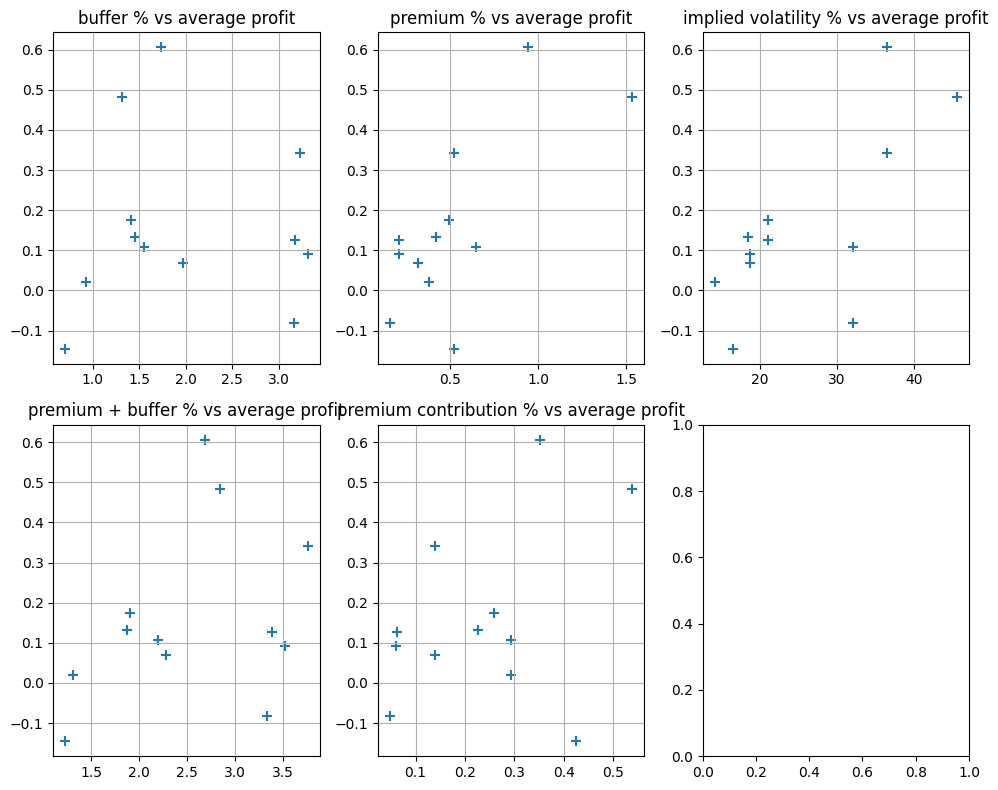

In [243]:
fig, axs = plt.subplots(2, 3, figsize=(10, 8))

axs[0, 0].scatter(buffer_percentage_list, average_profit_list, marker="+", s=50)
axs[0, 0].set_title('buffer % vs average profit')
axs[0, 0].grid(True)

axs[0, 1].scatter(premium_percentage_list, average_profit_list, marker="+", s=50)
axs[0, 1].set_title('premium % vs average profit')
axs[0, 1].grid(True)

axs[1, 0].scatter(buffer_plus_premium_list, average_profit_list, marker="+", s=50)
axs[1, 0].set_title('premium + buffer % vs average profit')
axs[1, 0].grid(True)

axs[1, 1].scatter(premium_percentage_contrib_list, average_profit_list, marker="+", s=50)
axs[1, 1].set_title('premium contribution % vs average profit')
axs[1, 1].grid(True)

axs[0, 2].scatter(iv_list, average_profit_list, marker="+", s=50)
axs[0, 2].set_title('implied volatility % vs average profit')
axs[0, 2].grid(True)

plt.tight_layout()

plt.show()

In [244]:
np.corrcoef(buffer_plus_premium_list, average_profit_list)

array([[1.        , 0.34643421],
       [0.34643421, 1.        ]])

In [245]:
np.corrcoef(premium_percentage_list, average_profit_list)

array([[1.        , 0.72432126],
       [0.72432126, 1.        ]])

In [246]:
np.corrcoef(buffer_percentage_list, average_profit_list)

array([[1.        , 0.02742736],
       [0.02742736, 1.        ]])

In [247]:
np.corrcoef(premium_percentage_contrib_list, average_profit_list)

array([[1.        , 0.36497502],
       [0.36497502, 1.        ]])

In [248]:
np.corrcoef(iv_list, average_profit_list)

array([[1.        , 0.69791848],
       [0.69791848, 1.        ]])